In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [2]:
# datasets: 'digits', 'fashion'
dataset = 'digits'

In [3]:
if dataset == 'digits':
    data = torchvision.datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }
elif dataset == 'fashion':
    data = torchvision.datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

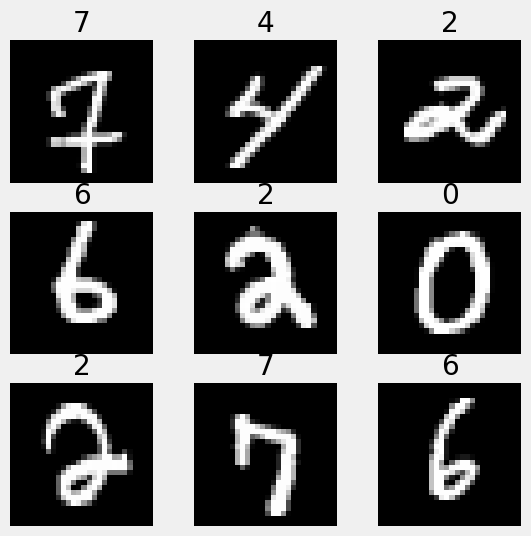

In [76]:
figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_index = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [77]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [164]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28+10, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2+10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 2)
        self.linear2 = nn.Linear(20, 2)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, label):
        y = nn.functional.one_hot(label, num_classes=10)
        z = torch.randn(2)
        z_cond = torch.cat((z, y), dim=1)
        return self.decoder(z_cond)

    def forward(self, x, y):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        return output, mu, logvar

VAE = VarAutoencoder()

In [165]:
learning_rate = 1e-4
batch_size = 32

In [166]:
loss_1 = nn.MSELoss()

In [167]:
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [168]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Epoch  0
loss1 tensor(0.2309) loss2 tensor(0.0449)
[23  0 31 22]


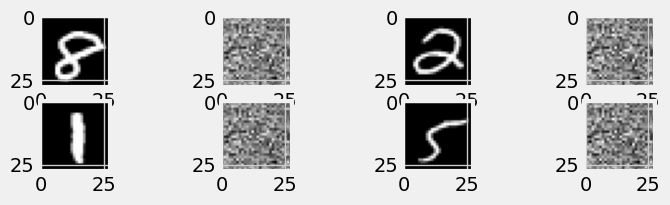

2.3085646629333496
Epoch  1
loss1 tensor(0.0579) loss2 tensor(4.7715)
[28 24 13  0]


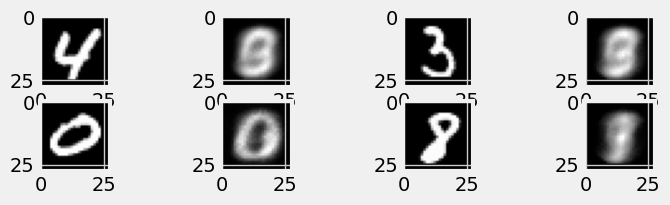

0.5835974216461182
Epoch  2
loss1 tensor(0.0523) loss2 tensor(5.5111)
[15 22 11 26]


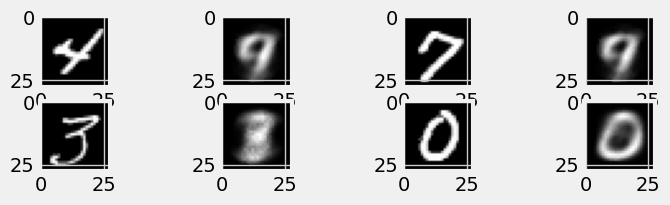

0.5286464691162109
Epoch  3
loss1 tensor(0.0507) loss2 tensor(5.1565)
[ 6 26 14  3]


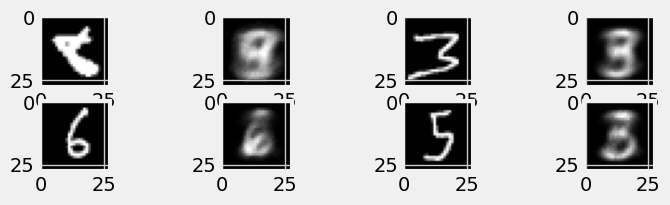

0.5121552348136902
Epoch  4
loss1 tensor(0.0479) loss2 tensor(5.5586)
[21 10  4  3]


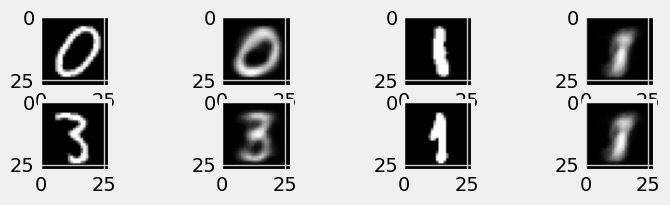

0.4849267303943634
Epoch  5
loss1 tensor(0.0461) loss2 tensor(6.5287)
[27  2 19 24]


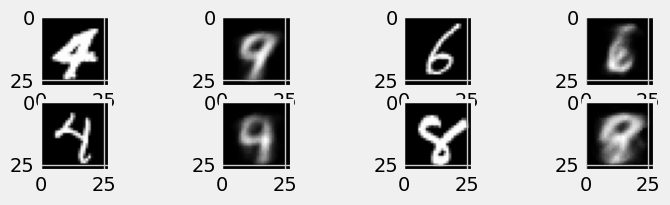

0.46759846806526184
Epoch  6
loss1 tensor(0.0472) loss2 tensor(6.5042)
[ 2 21  1 11]


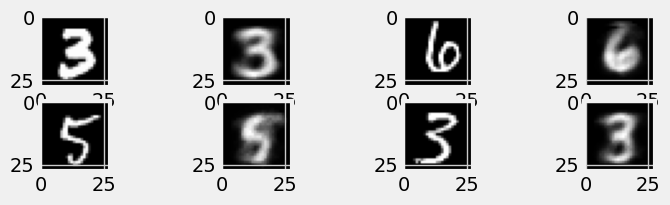

0.47854098677635193
Epoch  7
loss1 tensor(0.0427) loss2 tensor(6.7477)
[ 3 29  0  7]


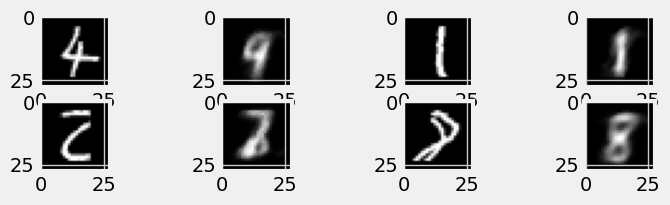

0.4336889088153839
Epoch  8
loss1 tensor(0.0414) loss2 tensor(6.7385)
[ 6 23 23 11]


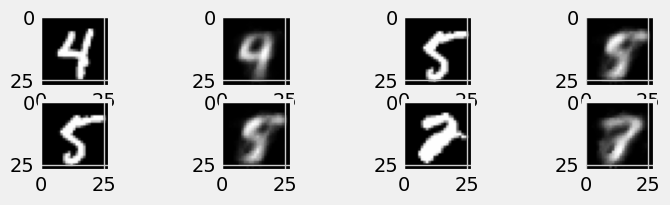

0.4211222231388092
Epoch  9
loss1 tensor(0.0413) loss2 tensor(6.1537)
[28  7 26 22]


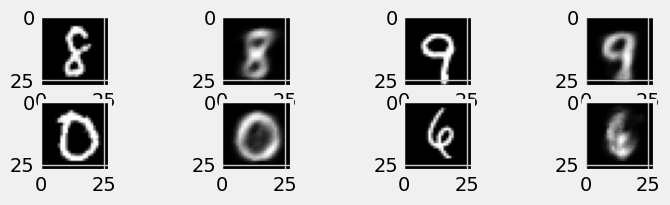

0.41962429881095886
Epoch  10
loss1 tensor(0.0417) loss2 tensor(6.2365)
[29 13 25 17]


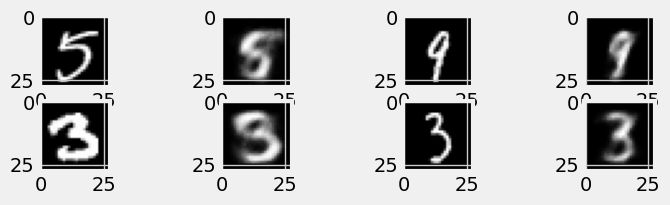

0.42304107546806335
Epoch  11
loss1 tensor(0.0401) loss2 tensor(6.7831)
[18 11 11 18]


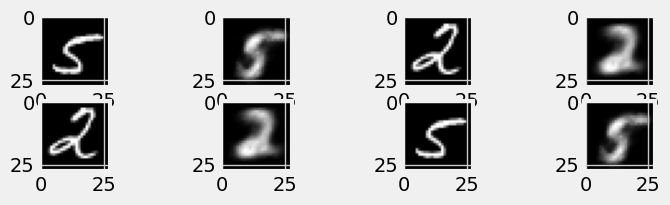

0.40774840116500854
Epoch  12
loss1 tensor(0.0380) loss2 tensor(6.9257)
[25 27 13  2]


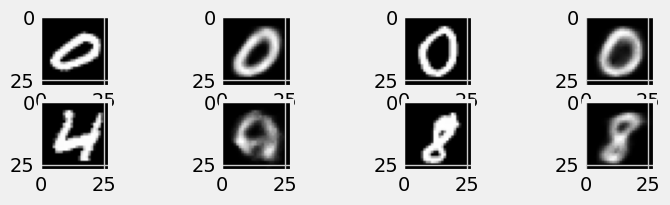

0.3870280683040619
Epoch  13
loss1 tensor(0.0393) loss2 tensor(6.6518)
[30 24 22 12]


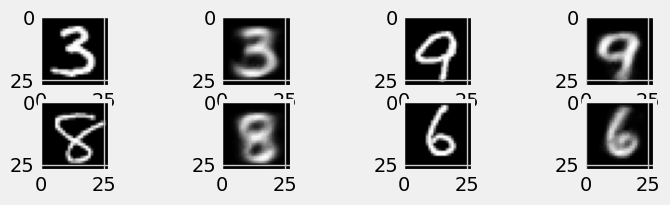

0.39960286021232605
Epoch  14
loss1 tensor(0.0377) loss2 tensor(7.0242)
[24 17 18  6]


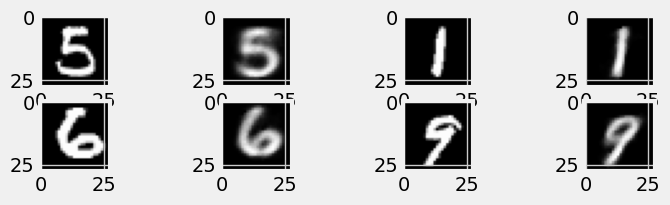

0.38419434428215027
Epoch  15
loss1 tensor(0.0418) loss2 tensor(6.9111)
[29  7 13 18]


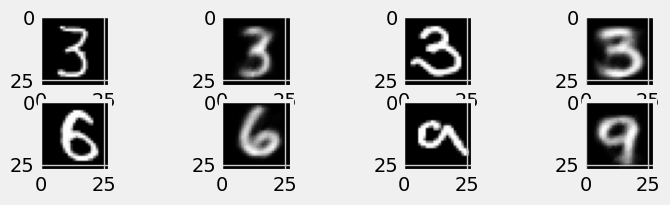

0.4248851239681244
Epoch  16
loss1 tensor(0.0396) loss2 tensor(6.5175)
[23 25 14 31]


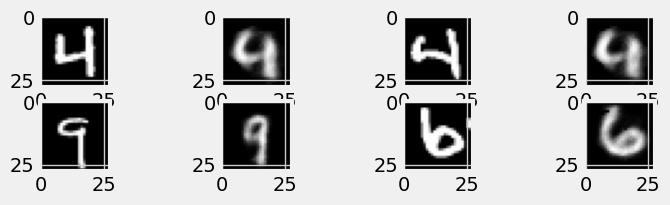

0.4021678566932678
Epoch  17
loss1 tensor(0.0401) loss2 tensor(6.6448)
[26 30  3 18]


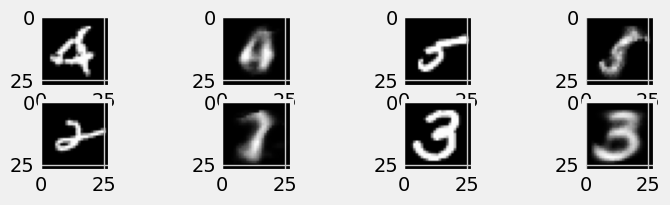

0.40741387009620667
Epoch  18
loss1 tensor(0.0373) loss2 tensor(6.5281)
[22  8 13 23]


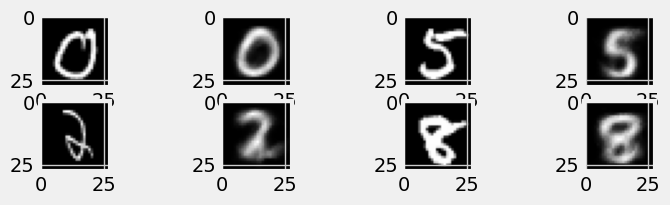

0.37958285212516785
Epoch  19
loss1 tensor(0.0359) loss2 tensor(6.7180)
[ 0  4  6 15]


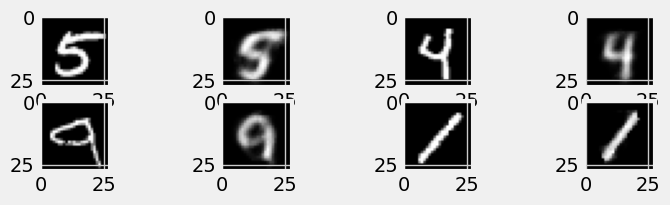

0.3656708598136902
Epoch  20
loss1 tensor(0.0388) loss2 tensor(7.0816)
[21 19 16 19]


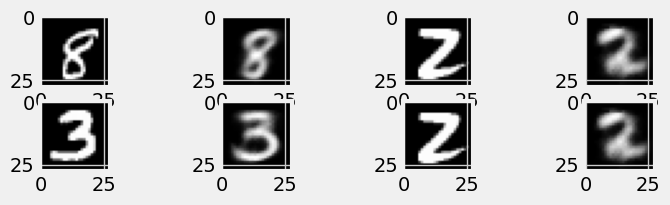

0.3948507606983185
Epoch  21
loss1 tensor(0.0373) loss2 tensor(6.5910)
[ 5  2 11 15]


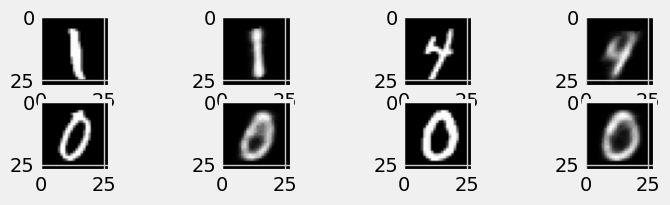

0.3800061345100403
Epoch  22
loss1 tensor(0.0394) loss2 tensor(7.2606)
[ 6  9 26 29]


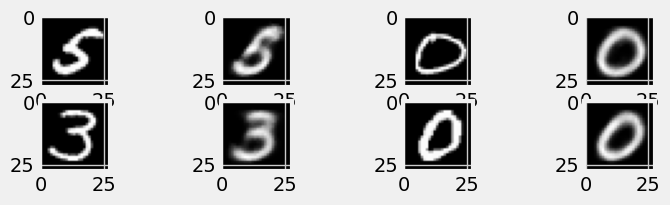

0.401746541261673
Epoch  23
loss1 tensor(0.0358) loss2 tensor(6.9843)
[14 17 21  2]


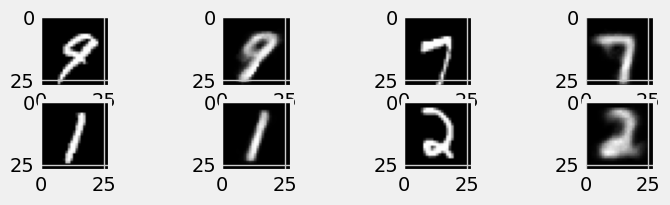

0.36476078629493713
Epoch  24
loss1 tensor(0.0347) loss2 tensor(7.2618)
[22 20  6  3]


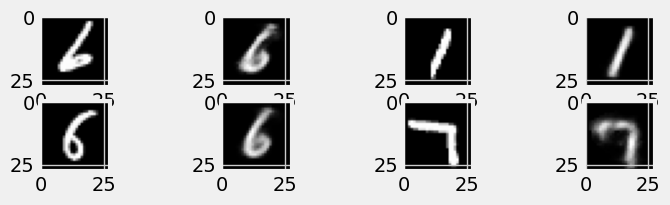

0.35441023111343384
Epoch  25
loss1 tensor(0.0356) loss2 tensor(7.2219)
[ 2  9 26  6]


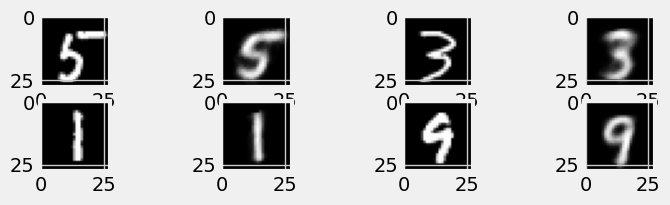

0.36330950260162354
Epoch  26
loss1 tensor(0.0387) loss2 tensor(6.7594)
[11  4 25 20]


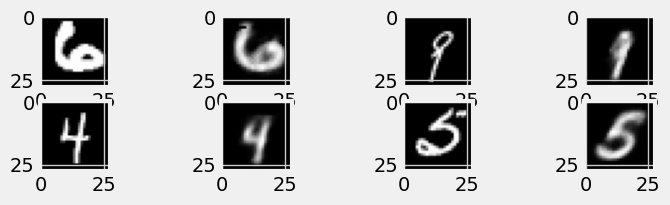

0.39369943737983704
Epoch  27
loss1 tensor(0.0399) loss2 tensor(6.8375)
[12 28 30 29]


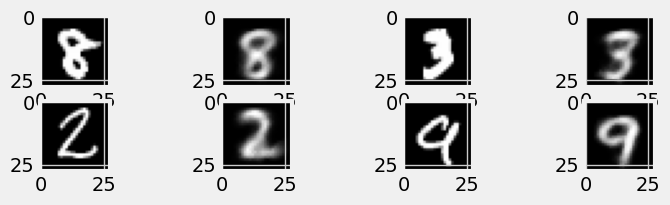

0.40558966994285583
Epoch  28
loss1 tensor(0.0326) loss2 tensor(6.7494)
[13  8 16  7]


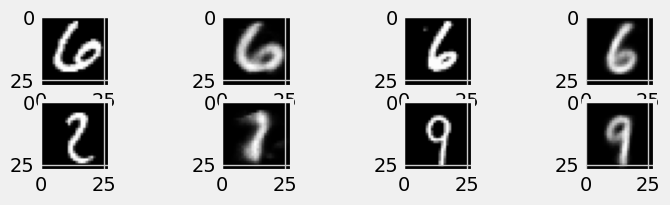

0.33264240622520447
Epoch  29
loss1 tensor(0.0367) loss2 tensor(7.1257)
[24  4 25  1]


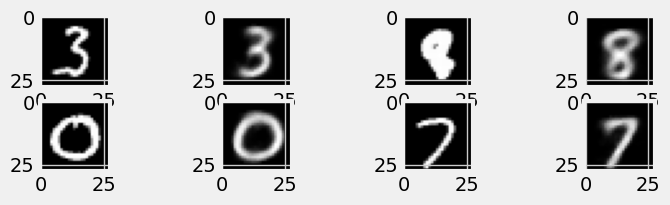

0.3738578259944916
Epoch  30
loss1 tensor(0.0371) loss2 tensor(7.2185)
[ 2 25  2 26]


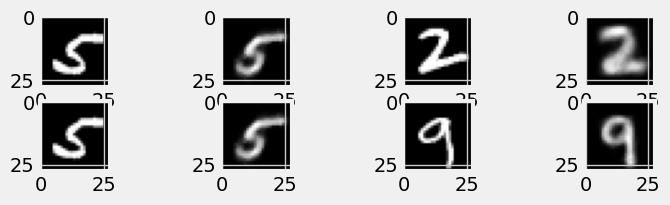

0.3778725564479828
Epoch  31
loss1 tensor(0.0364) loss2 tensor(7.0534)
[ 9 12 17 26]


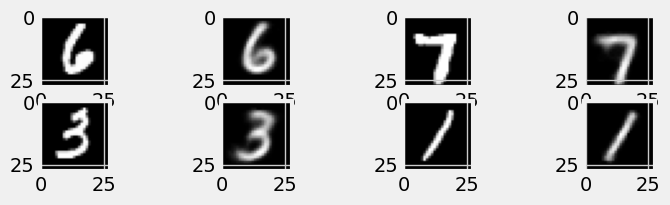

0.37094447016716003
Epoch  32
loss1 tensor(0.0336) loss2 tensor(7.0434)
[23 13 28  5]


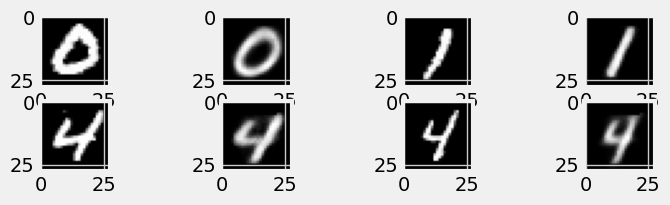

0.3433743119239807
Epoch  33
loss1 tensor(0.0362) loss2 tensor(6.6053)
[ 6 19 12 21]


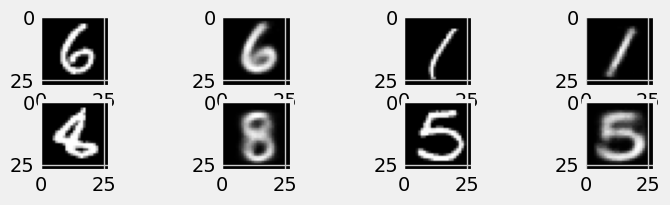

0.3685928285121918
Epoch  34
loss1 tensor(0.0376) loss2 tensor(6.5884)
[27 18 27  7]


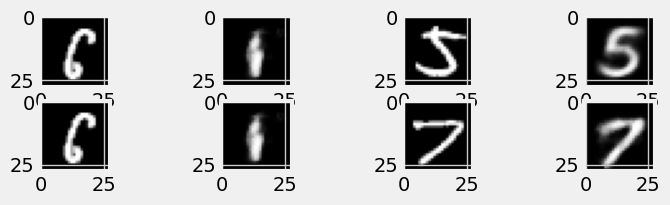

0.3822401165962219
Epoch  35
loss1 tensor(0.0383) loss2 tensor(6.4789)
[25 14  8 24]


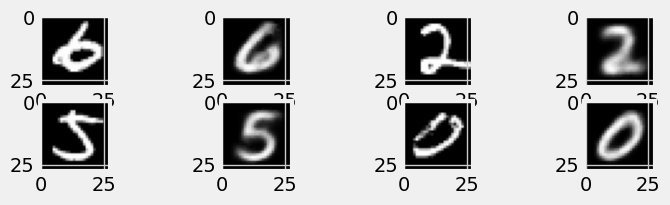

0.3894253075122833
Epoch  36
loss1 tensor(0.0322) loss2 tensor(6.6904)
[12 18  4  5]


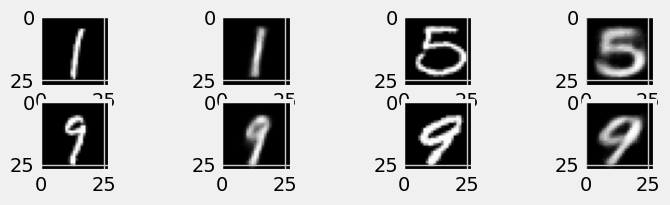

0.3283541798591614
Epoch  37
loss1 tensor(0.0352) loss2 tensor(7.1625)
[ 6 20 18 11]


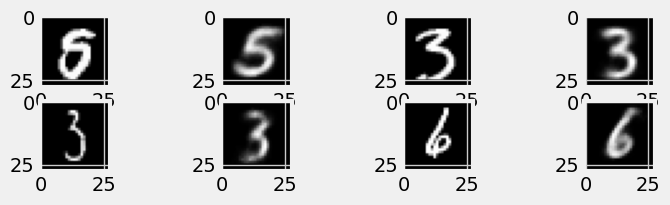

0.35906654596328735
Epoch  38
loss1 tensor(0.0329) loss2 tensor(6.6961)
[14  9  5  8]


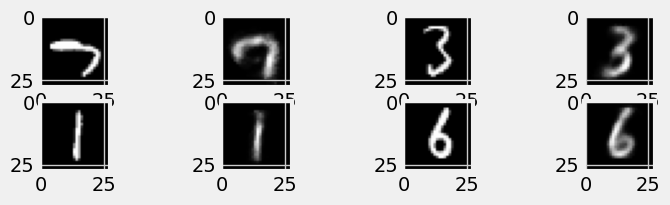

0.3355826437473297
Epoch  39
loss1 tensor(0.0388) loss2 tensor(6.7364)
[ 8  3 21  8]


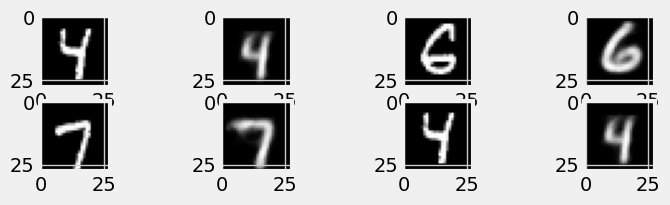

0.39507773518562317
Epoch  40
loss1 tensor(0.0428) loss2 tensor(7.1779)
[5 4 2 7]


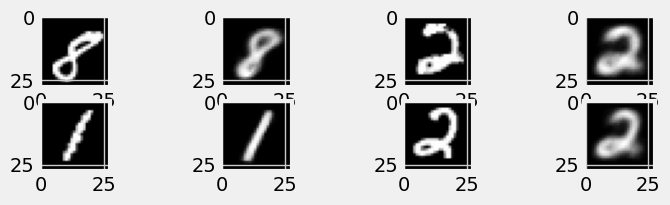

0.4350612163543701
Epoch  41
loss1 tensor(0.0337) loss2 tensor(6.7763)
[16  7 29 12]


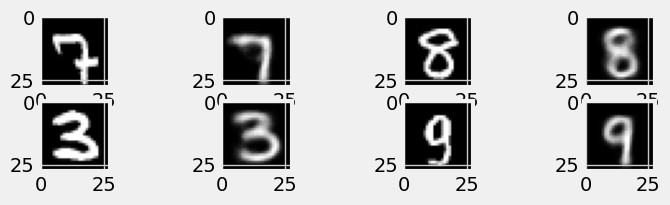

0.34419599175453186
Epoch  42
loss1 tensor(0.0301) loss2 tensor(7.0940)
[20 12  1 26]


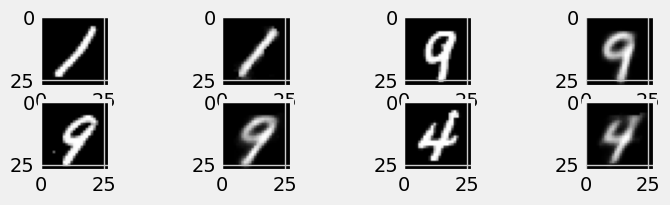

0.30856603384017944
Epoch  43
loss1 tensor(0.0340) loss2 tensor(6.9339)
[29  9 23  6]


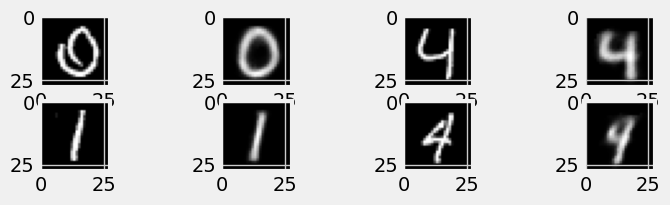

0.34683263301849365
Epoch  44
loss1 tensor(0.0359) loss2 tensor(6.8991)
[25  4  9 30]


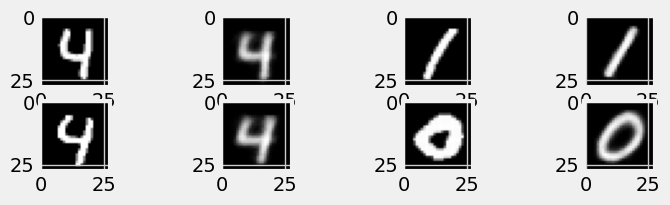

0.3655525743961334
Epoch  45
loss1 tensor(0.0398) loss2 tensor(6.7001)
[ 2 24 17 13]


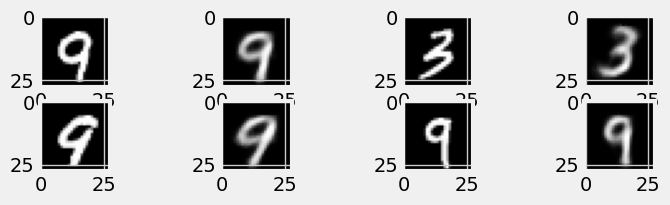

0.40460991859436035
Epoch  46
loss1 tensor(0.0349) loss2 tensor(6.8037)
[30  9 18  7]


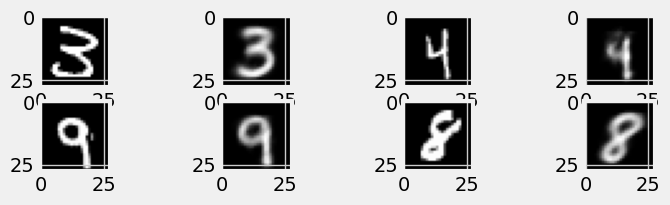

0.35629770159721375
Epoch  47
loss1 tensor(0.0364) loss2 tensor(7.0829)
[ 8 17 21 25]


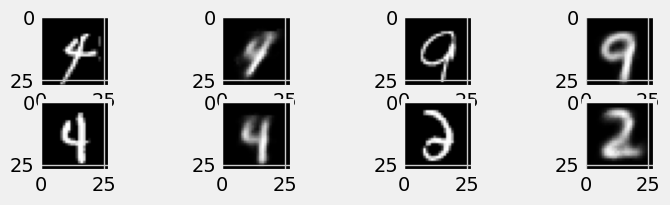

0.37144243717193604
Epoch  48
loss1 tensor(0.0365) loss2 tensor(6.7894)
[16 20 29 12]


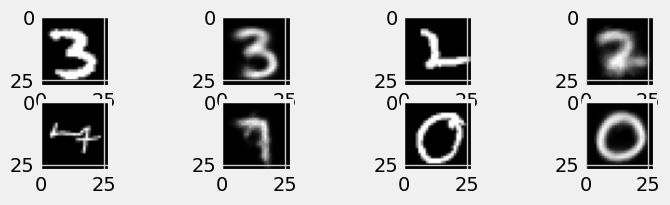

0.37180256843566895
Epoch  49
loss1 tensor(0.0348) loss2 tensor(6.7271)
[16  1  2  1]


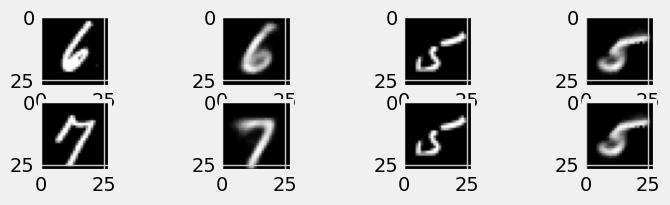

0.35465723276138306


In [169]:
# Training loop
epochs = 50
losses = []
beta1 = 10
beta2 = 0.001
for epoch in range(epochs):
    plot = True

    VAE.train()
    for (image, label) in data_loader:

        # Reshape image, label for input
        image = image.reshape(-1, 784)
        label = nn.functional.one_hot(label, num_classes=10)
        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if plot==True:
            fig = plt.figure(figsize=(8,4))
            print('Epoch ', epoch)
            with torch.no_grad():
                print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                recon_plot = reconstruction.reshape(-1, 28, 28)
                images_plot = image.reshape(-1, 28, 28)
                indices = numpy.random.choice(32, 4)
                print(indices)
                for i, ind in enumerate(indices):
                    ax1 = fig.add_subplot(4,4,2*i+1)
                    ax1.imshow(images_plot[ind], cmap='gray')
                    ax2 = fig.add_subplot(4,4,2*i+2)
                    ax2.imshow(recon_plot[ind], cmap='gray')
            
            plt.show()
            print(losses[-1])
            plot=False

        

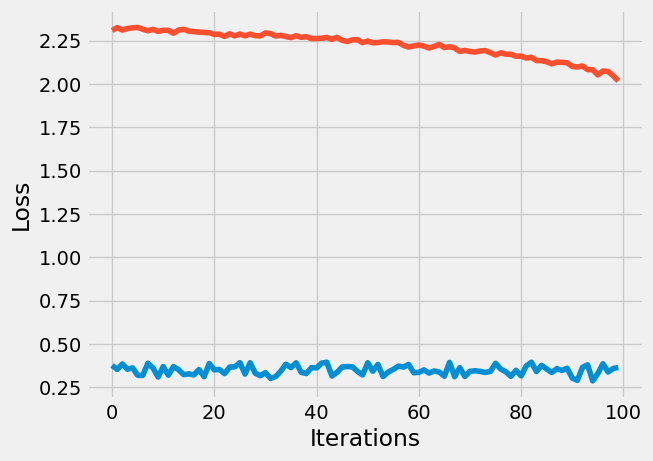

In [170]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.plot(losses[:100])

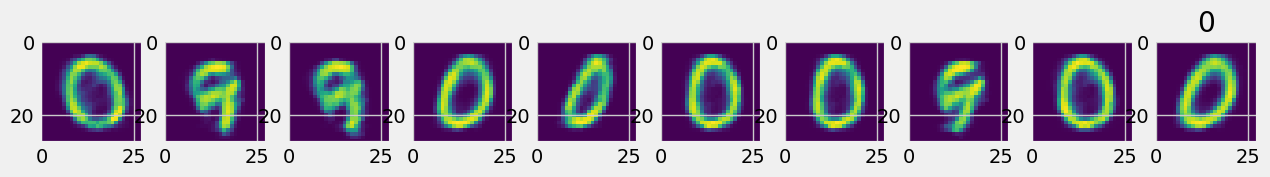

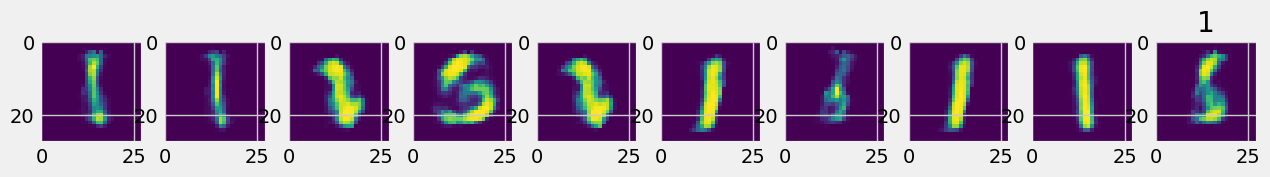

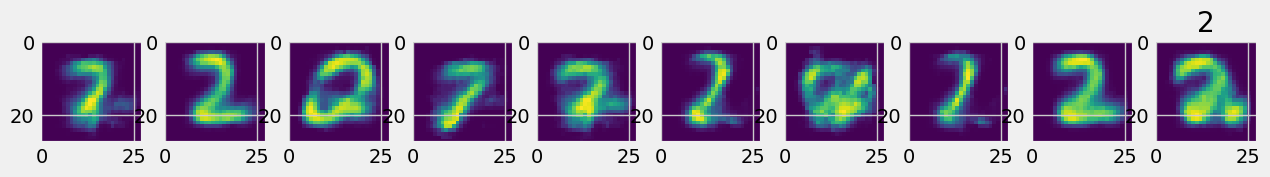

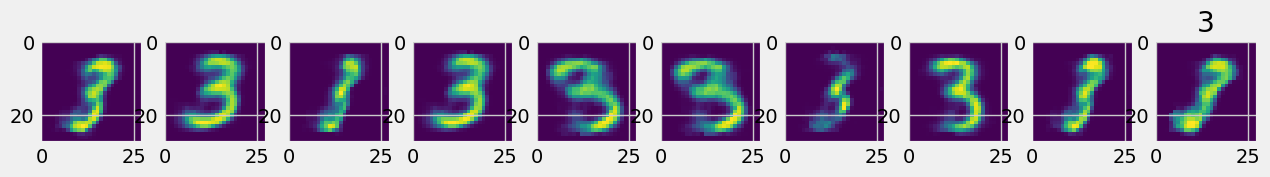

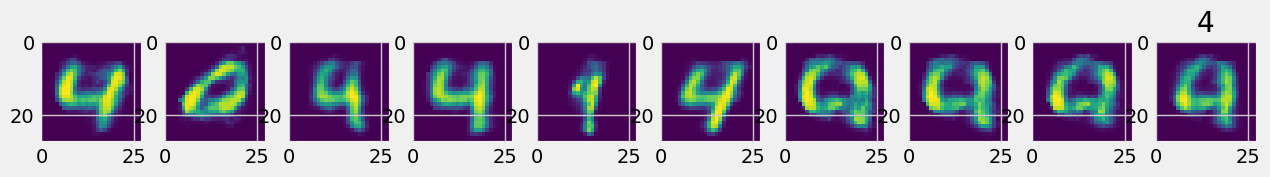

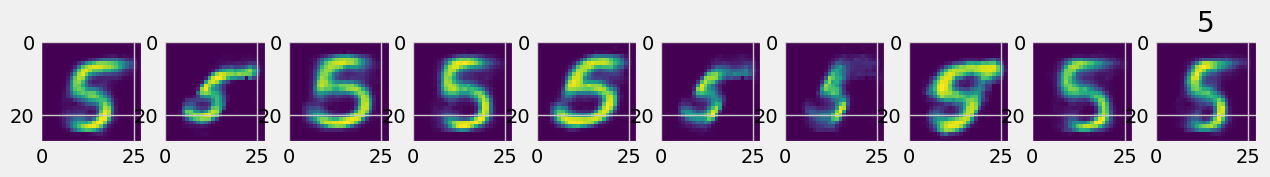

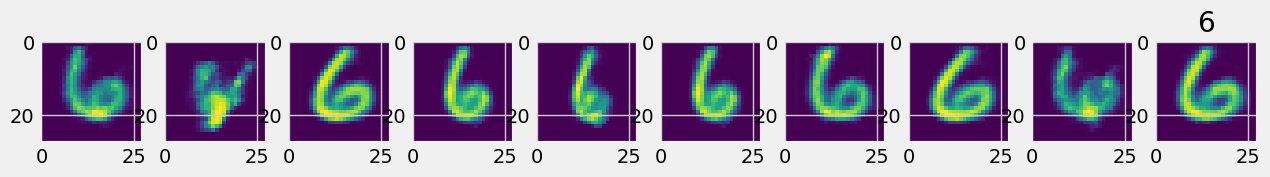

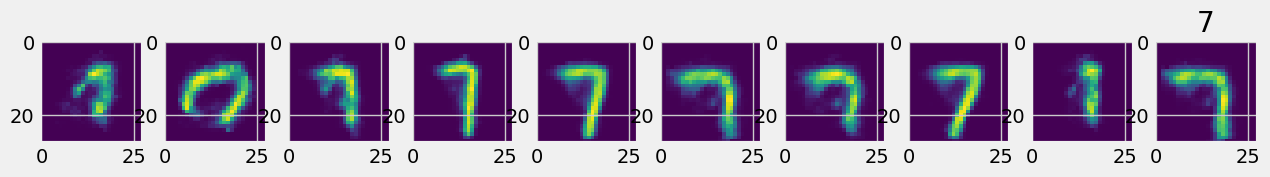

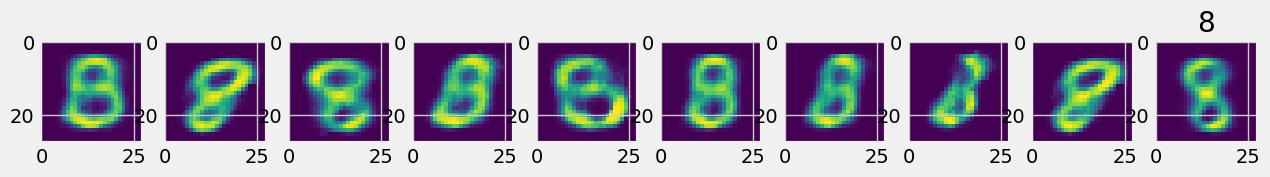

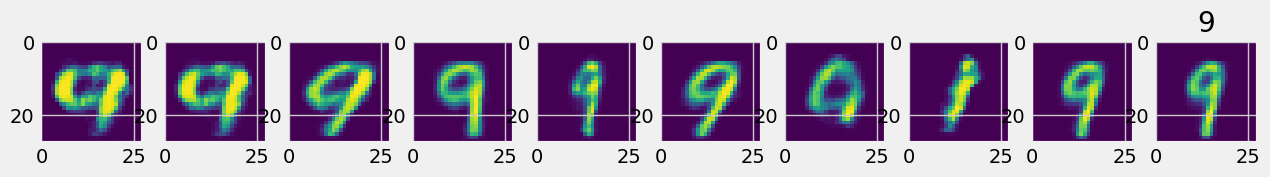

In [176]:
# Decoding randomly generated latent space points

sample_index = numpy.random.randint(len(data))
img, label = data[sample_index]
img = img.reshape(-1,784)
label = torch.unsqueeze(nn.functional.one_hot(torch.tensor(label), num_classes=10), 0)
for j in range(10):
    fig = plt.figure(figsize=(14,10))
    with torch.no_grad():
        for i in range(10):
            z = VAE.encoder(torch.cat((img, label), dim=1))
            z = VAE.linear1(z)
            y = torch.unsqueeze(nn.functional.one_hot(torch.tensor(j), num_classes=10),0)
            z_rand = torch.randn(z.shape)
            z_cond = torch.cat((z_rand, y), dim=1)
            x = VAE.decoder(z_cond)
            ax = fig.add_subplot(1,10,i+1)
            ax.imshow(x.squeeze().reshape(28,28))
    plt.title(j)
    plt.show()